In [53]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Model, Sequential
from keras.layers import Input, Dense, Layer, Conv2D, MaxPool2D, Flatten, Conv2DTranspose, Reshape, BatchNormalization, LeakyReLU, Lambda,Cropping2D
from keras.losses import Loss, binary_crossentropy, mean_squared_error
from keras.optimizers import Optimizer, Adam
from keras.metrics import Mean
from sklearn.model_selection import KFold
from keras.utils import to_categorical, plot_model, load_img, img_to_array
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from keras.models import load_model

# Variational Autoencoder: Layer Classes

In [3]:
def printest(args, valor):
    return print( "{} : \n {} \n".format(args, valor) )

In a Variational Autoencoder (VAE), the layer that takes the parameters of the distribution (mean and variance) is typically placed in the Latent class. The Encoder class is responsible for encoding the input data into a lower-dimensional latent space, while the Latent class parameterizes the distribution from which the latent vectors are sampled. The Decoder class is then responsible for generating a reconstruction of the original data from the latent vectors sampled from the distribution parameterized by the Latent class.

Specifically, in the Latent class, the mean and variance are typically computed based on the output of the encoder network, and then used to sample a vector from the corresponding distribution (e.g. Gaussian). This vector is then passed to the Decoder class to generate a reconstruction of the input data.

## Encoder

A common sequence of layers for an encoder in a convolutional autoencoder is a series of Conv2D layers with a ReLU activation function, followed by a MaxPooling layer or not. Here I choose to work with the Conv2D layer follow by a BatchNormalization Layer, and a LeakyReLU Layer.

**Layers chosen:**

- Conv2D with relu : Convolutional Layer to learn complex features
  
- BatchNormalization : Normalizes the input values (or activations) of each layer to have zero mean and unit variance
  
- LeakyRelu : allow a small, non-zero output for negative inputs. In a standard ReLU, if the input is negative, the output is zero. This can cause some neurons to "die" and never activate again if they receive a series of negative inputs.

- Flatten: In the last Layer of the Encoder the Flatten layer is used to convert the output tensor from the previous layer into a 1D tensor

The encoder network then takes an input (e.g., an image) and computes a set of features, which are passed to the latent space. Let use the following notation to represent this network:

$$y = Encoder(x)$$

Here, $x$ is the input data, and $Encoder$ is the encoder network that outputs a set of features $y$.

In [245]:
class Encoder(Layer):
    def __init__(self,
                img_shape: tuple = (28,28,1),
                filters: list = [32,64,64,64], 
                filter_sizes: list = [3,3,3,3], 
                conv_strides: list = [1,2,2,1], 
                padding = "same",
                activation: str = 'relu', 
                initializer: str = 'he_uniform',
                name: str = 'Encoder') -> None:
        """
        Encoder Layer.

        Parameters:
        img_shape: 3D tuple defining the input shape of the image (rows, cols, channels).
        filters (list): A list containing the number of filters to be used in each convolutional layer.
        filter_sizes (list): A list containing the size of the filters to be applied in each convolutional layer.
        conv_strides (list): A list containing the strides of the convolution operation for each layer.
        padding (str): The padding strategy to be used in the convolutional layers.
        activation (str): The activation function to be used in the convolutional layers.
        initializer (str): The initializer to be used in the convolutional layers.
        """

        super(Encoder, self).__init__(name = name)
        self.img_shape = img_shape
        self.encoder_output_shape = None
        self.filters = filters
        self.filter_sizes = filter_sizes
        self.conv_strides = conv_strides
        self.padding = padding
        self.activation = activation
        self.initializer = initializer


        ### Define the parameters to be passed for the Decoder Layer ###
        
        # The number of filters to be used in each convolutional layer
        self.decoder_filters = filters 
        # The size of the filters to be applied in each convolutional layer
        self.decoder_filter_sizes = filter_sizes 
        # The stride of the convolutional layer
        self.decoder_strides = conv_strides 
        
        # Create convolutional layers
        self.encoder_layer = []
        for i in range(len(filters)):
            self.encoder_layer.append(Conv2D(filters = self.filters[i], 
                                      kernel_size = self.filter_sizes[i],
                                      strides = conv_strides[i], 
                                      padding = padding,
                                      kernel_initializer = self.initializer,
                                      activation = self.activation,
                                      name='Conv2D_{}'.format(i)))
            
            self.encoder_layer.append(BatchNormalization(name='EncoderBatchNormalization_{}'.format(i)))
            self.encoder_layer.append(LeakyReLU(name='EncoderLeakyReLU_{}'.format(i)))

        # Flatten Layer 1D array
        self.flatten = Flatten(name='EncoderFlatten')

        

    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        Forward pass of the network.

        Parameters:
        x: Input tensor.

        Returns:
        x: Output tensor (flattened).
        """
        for layer in self.encoder_layer:
            x = layer(x)
        return self.flatten(x)
    
    def get_output_shapes(self) -> list:
        
        """
        Returns the output shapes of each Conv2D Layer from the encoder.

        Returns:
        encoder_output_shape (list): list with the output shapes of Conv2D layers.
        """
        x = Input(self.img_shape)

        self.output_shapes = []
        for layer in self.encoder_layer:
            if isinstance(layer, Conv2D):
                x = layer(x)
                self.output_shapes.append(x.shape[1:])  
        return self.output_shapes

## Latent

The latent space takes the features $y$ from the encoder and computes the mean $\mu$ and log variance $\log(\sigma^2)$. These parameters define a Gaussian distribution in the latent space.
$$\mu = Latent_\mu(y)$$

$$log(\sigma^2) = Latent_{log(\sigma^2)}(y)$$

Here, $y$ are the features from the encoder, and $Latent_\mu$ and $Latent_{log(\sigma^2)}$ are functions that output the mean and log variance, respectively.



In [246]:
class Latent(Layer):
    def __init__(self, 
                encoder: Encoder,  
                dense_units: int = 32,
                dense_activation: str = 'relu',
                mean_var_units: int = 2,  
                mean_var_activation: str = None, 
                initializer: str = 'he_uniform',
                name: str = 'Latent'  
                ) -> None:   

        """
        Latent Layer.
        
        Parameters:
        encoder (Encoder): An instance of the Encoder class.
        layer_sizes (int): The number of units (neurons) to be used in the Dense layer.
        activation (str): The activation function to be used in the Dense layers.
        initializer (str): The initializer to be used in the Dense layers.
        """

                       
        super(Latent, self).__init__(name = name)
        self.encoder = encoder  
        self.dense_units = dense_units
        self.dense_activation = dense_activation  
        self.mean_var_units = mean_var_units  
        self.mean_var_activation = mean_var_activation
        self.initializer = initializer  


        
        self.dense_layer = Dense( units = self.dense_units, 
                                kernel_initializer = self.initializer, 
                                activation = self.dense_activation,
                                name = 'DenseLatent' )
        
        # Dense layer for mean
        self.mean_layer = Dense(units=self.mean_var_units, 
                                activation = self.mean_var_activation,
                                kernel_initializer=self.initializer,
                                name='Mean')
        
        # Dense layer for log-variance
        self.log_var_layer = Dense(units=self.mean_var_units, 
                                  activation = self.mean_var_activation,
                                  kernel_initializer=self.initializer,
                                  name='LogVar')

    def call(self, x: tf.Tensor) -> tf.Tensor:

        """
        Forward pass of the Latent layer.

        Args:
        x (tf.Tensor): The input tensor.

        Returns:
        x (tf.Tensor): A list containing the mean and log-variance tensors.
        """
        x = self.dense_layer(x)
        # compute mean and log variance
        mean = self.mean_layer(x)
        log_var = self.log_var_layer(x)
        return  [mean, log_var]

## Sampling

**Reparameterization trick**

The reparameterization trick is crucial for training the VAE because it enables backpropagation through the sampling process, which would otherwise be non-differentiable. By introducing a random noise vector $\epsilon$ and transforming it using the mean $\mu$ and standard deviation $\sigma$, we can optimize the VAE's parameters during training by computing gradients through the differentiable transformation.

This trick involves introduces a new variable $\epsilon$ which is sampled from a standard normal distribution $N(0,I)$, where $I$ is the identity matrix. Then, we obtain a sample $z$ from the desired distribution by transforming $\epsilon$ using the mean $\mu$ and standard deviation $\sigma$ obtained from the encoder output:

$$z = \mu + \sigma \odot \epsilon$$

Here, $\sigma$ is the standard deviation, obtained as  $\sigma^2 = \exp(\log(\sigma^2))$ or $\sigma= \exp{(\frac{log(\sigma^2)}{2})}$, and $\epsilon$ is a random noise vector sampled from a standard normal distribution. This transformation is differentiable, so we can backpropagate through it to train the network. 

In [247]:
class Sampling(Layer):
    def __init__(self, latent: Latent, name: str = 'Sampling'):
        """
        Initialize the Sampling layer.

        Args:
            latent (Latent): Latent layer instance, used to obtain mean and log variance values.
        """
        super(Sampling, self).__init__(name = name)

        self.latent = latent

        # Create a Lambda layer that applies the sampling function
        self.z_layer = Lambda(self.sampling, name="ZLayer")

    def sampling(self, args):
        """
        Sampling function to generate z using the reparameterization trick.

        Args:
            args (list): List containing z_mean and z_log_var tensors.

        Returns:
            z (tensor): Sampled latent vector.
        """
        z_mean, z_log_var = args
        # Sample epsilon from a standard normal distribution with the same shape as mean
        epsilon = tf.random.normal(
            shape=tf.shape(z_mean), mean=0.0, stddev=1.0)
        # Compute z using the reparameterization trick
        z = z_mean + tf.math.exp(z_log_var / 2) * epsilon
        return z

    def call(self, inputs):
        """
        Forward pass of the Sampling layer.

        Args:
            inputs (list): List containing z_mean and z_log_var tensors.

        Returns:
            z (tensor): Sampled latent vector.
        """
        z_mean, z_log_var = inputs
        
        # Apply the Lambda layer with the sampling function to obtain z
        z = self.z_layer([z_mean, z_log_var])

        return z


## Decoder

While the Conv2D layer performs a downsampling operation by reducing the spatial dimensions of the input feature map, the Conv2DTranspose layer performs an upsampling operation by increasing the spatial dimensions of the input feature map. It achieves this by "padding" the input feature map with zeros and then applying a convolution operation on it.

Using a Conv2DTranspose layer in the decoder allows the network to learn to recover the spatial information that was lost during the downsampling operation in the encoder. It also allows for more flexibility in the size of the output feature map, since the output size can be adjusted by changing the stride and padding parameters of the layer.

The decoder network takes the sampled latent vector $z$ and attempts to reconstruct the original input data:
$$\hat{x} = Decoder(z)$$

Here, $\hat{x}$ is the reconstructed input data, and $Decoder$ is the decoder network.

In [248]:
class Decoder(Layer):
    def __init__(self,
                sampling: Sampling,
                activation: str = 'relu',
                initializer: str = 'he_uniform',
                name: str = 'Decoder') -> None:
        """
        Decoder Layer.

        Parameters:
        sampling (Sampling): An instance of the Sampling class.
        activation (str): The activation function to be used in the Dense and convolutional layers.
        initializer (str): The initializer to be used in the Dense and convolutional layers.
        """
        super(Decoder, self).__init__(name = name)
        
        self.sampling = sampling
        self.activation = activation
        self.initializer = initializer

        # Get the parameters from the encoder to reconstruct the original image
        self.img_shape = sampling.latent.encoder.img_shape                              #(weight, height, filters)
        self.decoder_filters = sampling.latent.encoder.decoder_filters
        self.decoder_filter_sizes = sampling.latent.encoder.decoder_filter_sizes
        self.decoder_strides = sampling.latent.encoder.decoder_strides
        self.encoder_padding = sampling.latent.encoder.padding
        self.encoder_output_shape = sampling.latent.encoder.get_output_shapes()[-1]     #( height, weight, filters)
        ##-------------------------------------------------------------------------

        # Create a dense layer to reshape the input tensor
        pixels = np.prod(self.encoder_output_shape)
        self.dense = Dense(units = pixels,              ##(height, weight, filters)
                           kernel_initializer=self.initializer, 
                           activation=self.activation,
                           name='DecoderDense')

        # Reshape the output of the dense layer to match the shape of the last convolutional layer in the encoder
        self.reshape = Reshape(target_shape = self.encoder_output_shape, name='DecoderReshape')

        # Create convolutional layers to upsample
        self.conv2d_transpose = []
        for i in range(len(self.decoder_filters)):
            self.conv2d_transpose.append(Conv2DTranspose(filters = self.decoder_filters[i], 
                                                         kernel_size = self.decoder_filter_sizes[i],
                                                         strides = self.decoder_strides[i], 
                                                         padding = self.encoder_padding,
                                                         kernel_initializer = self.initializer,
                                                         activation = self.activation,
                                                         name='Conv2DTranspose_{}'.format(i)))

            self.conv2d_transpose.append(BatchNormalization(name='DecoderBatchNormalization_{}'.format(i)))
            self.conv2d_transpose.append(LeakyReLU(name='DecoderLeakyReLU_{}'.format(i)))


        # Calculate the absolute difference between the output tensor shape and the expected image shape
        current_output_shape = self.get_output_shapes()[-1]
        height_diff = abs(current_output_shape[0] - self.img_shape[0])
        width_diff = abs(current_output_shape[1] - self.img_shape[1])   

        kernel_height = 1 if current_output_shape[0] >= self.img_shape[0] else height_diff + 1
        kernel_width = 1 if current_output_shape[1] >= self.img_shape[1] else width_diff + 1
        self.rescale = Conv2DTranspose(
            filters = 1, 
            kernel_size = (kernel_height, kernel_width), 
            kernel_initializer=self.initializer,
            activation='sigmoid',      
            name='RescaleConv2DTranspose'
        )
        self.crop = Cropping2D(cropping=((height_diff // 2, height_diff - height_diff // 2),
                                    (width_diff // 2, width_diff - width_diff // 2)),
                        name='CropLayer')
        
    def call(self, x) -> tf.Tensor:

        """
        Forward pass of the decoder network.

        Parameters:
        x: Input tensor.

        Returns:
        x: Output tensor.
        """
        x = self.dense(x)
        x = self.reshape(x)

        # Pass the reshaped tensor through the convolutional transpose layers
        for conv_layer in self.conv2d_transpose:
            x = conv_layer(x)  

        # Rescale the output to have the same size as the original image
        output_size = x.shape[1:3]
        input_size = self.img_shape[:2]
        if output_size!= input_size:
            if x.shape[1] <= self.img_shape[0] or x.shape[2] <= self.img_shape[1]:
                x = self.rescale(x)
            else:
                x = self.crop(x)
                x = self.rescale(x)
        else:
            x = self.rescale(x)
  
        return x
    
    def get_output_shapes(self) -> tuple:
        """
        Returns the output shapes of each Conv2DTranspose layer in the decoder.

        Returns:
        output_shapes (tuple): A list of output shapes from the Conv2DTranspose layers.
        """
        x = Input(self.encoder_output_shape)

        self.output_shapes = []
        for layer in self.conv2d_transpose:
            if isinstance(layer, Conv2DTranspose):
                x = layer(x)
                self.output_shapes.append(x.shape[1:])
        
        return self.output_shapes

# Variational Autoencoder: Model

The VAE model is trained by minimizing a loss function that consists of two parts:

- Reconstruction loss: 

This measures the difference between the input data $x$ and the reconstructed data $\hat{x}$. It encourages the decoder to produce accurate reconstructions of the input data. The binary cross-entropy loss is used to measure this difference:

$$L_{reconstruction} = -\sum_{i=1}^{n} x_i \log(\hat{x}_i) + (1 - x_i) \log(1 - \hat{x}_i)$$

Even though the input and output are not binary classification labels. The reason is that the binary cross-entropy loss measures the difference between two probability distributions, and in this case, we can treat the input and reconstructed data as probability distributions.

The term $x_i \log(\hat{x}_i)$ corresponds to the contribution of the "positive" aspect of a feature, meaning that the feature is present in the input data ($x_i = 1$). The term $(1 - x_i) \log(1 - \hat{x}_i)$ corresponds to the contribution of the "negative" aspect of a feature, meaning that the feature is absent in the input data ($x_i = 0$).The negative sign is used because the logarithm of values between 0 and 1 is negative, and we want to minimize the loss.


  - Kullback-Leibler (KL) divergence: 
   
This measures the difference between the learned latent distribution (with parameters µ and σ) and a standard normal distribution. It acts as a regularization term, encouraging the latent space to have a meaningful and structured representation.
$$L_{KL} = -\frac{1}{2} \sum_{j=1}^{k} (1 + \log(\sigma_j^2) - \mu_j^2 - \sigma_j^2)$$

The total loss for the VAE is the sum of the reconstruction loss and the KL divergence:

$$L_{VAE} = \alpha L_{reconstruction} + \beta L_{KL}$$

In [252]:
class VAE(Model):
    def __init__(self, 
                 encoder: Encoder,
                 latent: Latent,
                 sampling: Sampling,
                 decoder: Decoder,
                 alpha: int = 1,
                 beta: int = 1 ):
        """
        Variational Autoencoder (VAE) class that combines Encoder, Latent, Sampling, and Decoder components.

        Parameters:
        encoder (Encoder): Encoder layer instance.
        latent (Latent): Latent layer instance.
        sampling (Sampling): Sampling layer instance.
        decoder (Decoder): Decoder layer instance.
        alpha (int): Weight for the reconstruction loss.
        beta (int): Weight for the KL-divergence loss.
        """
        super(VAE, self).__init__()

        # Assign the provided components
        self.encoder = encoder
        self.latent = latent
        self.sampling = sampling
        self.decoder = decoder

        # Set the alpha and beta weights for the losses
        self.beta = beta
        self.alpha = alpha
        
        # Initialize loss trackers
        self.total_loss_tracker = Mean(name="total_loss")
        self.reconstruction_loss_tracker = Mean( name="reconstruction_loss" )
        self.kl_loss_tracker = Mean(name="kl_loss")

    def call(self, x):
        # Pass the input through the Encoder
        x = self.encoder(x)
        # Compute the mean and log-variance of the latent distribution
        z_mean, z_log_var = self.latent(x)
        # Sample a latent point from the distribution
        z = self.sampling([z_mean, z_log_var])
        x  = self.decoder(z)
        
        return x, z_mean, z_log_var 
    
    def build_model(self): 
        x = Input((28,28,1), name = "Input")
        return Model( inputs = x, 
                      outputs = self.call(x) )
    
    # Define metrics property to return the loss trackers
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    # Train step function
    def train_step(self, data):
        return self._process_step(data, training = True)
    
    # Test step function
    def test_step(self, data):
        return self._process_step(data, training = False)
    
    # Shared function for both train and test steps
    def _process_step(self, data, training):
        # Unpack the data tuple
        x, y = data

        # Record operations for automatic differentiation
        with tf.GradientTape(persistent = True) as tape:
            # Forward pass through the VAE
            y_pred, z_mean, z_log_var = self(x, training = training )
            # Compute the total loss
            total_loss  = self.compute_loss(y , y_pred, z_mean, z_log_var)

        # Compute and apply gradients if in training mode
        if training:
            grads = tape.gradient(total_loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Update the loss trackers
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(self.reconstruction_loss)
        self.kl_loss_tracker.update_state(self.kl_loss)
        
        # Return the losses as a dictionary
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    def compute_loss(self, x, y_pred, z_mean, z_log_var):
        """
        Compute the total loss as a combination of reconstruction and KL-divergence losses.

        Args:
        x: Input data.
        y_pred: Predictions returned by the model (output of `model(x)`).
        z_mean: Mean of the latent distribution.
        z_log_var: Log-variance of the latent distribution.

        Returns:
        The total loss as a `tf.Tensor`.
        """
        # Compute the reconstruction loss (pixel-wise mean squared error)
        self.reconstruction_loss = self.alpha * tf.reduce_mean(binary_crossentropy(x , y_pred))

        # Compute the KL-divergence loss
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        self.kl_loss = self.beta * tf.reduce_mean(kl_loss, axis=1)
        
        # Calculate the total loss as the sum of the reconstruction and KL-divergence losses
        total_loss = self.reconstruction_loss + self.kl_loss

        return total_loss



## Graph and Summary

In [213]:
input = Input((28,28,1))
encoder = Encoder()
latent = Latent(encoder)
sampling = Sampling(latent)
decoder = Decoder(sampling)

vae = Model(inputs = input, outputs = decoder.call(sampling.call( latent.call(encoder.call(input)))))

vae.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_92 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 Conv2D_0 (Conv2D)              (None, 28, 28, 32)   320         ['input_92[0][0]']               
                                                                                                  
 EncoderBatchNormalization_0 (B  (None, 28, 28, 32)  128         ['Conv2D_0[1][0]']               
 atchNormalization)                                                                               
                                                                                                  
 EncoderLeakyReLU_0 (LeakyReLU)  (None, 28, 28, 32)  0           ['EncoderBatchNormalizatio

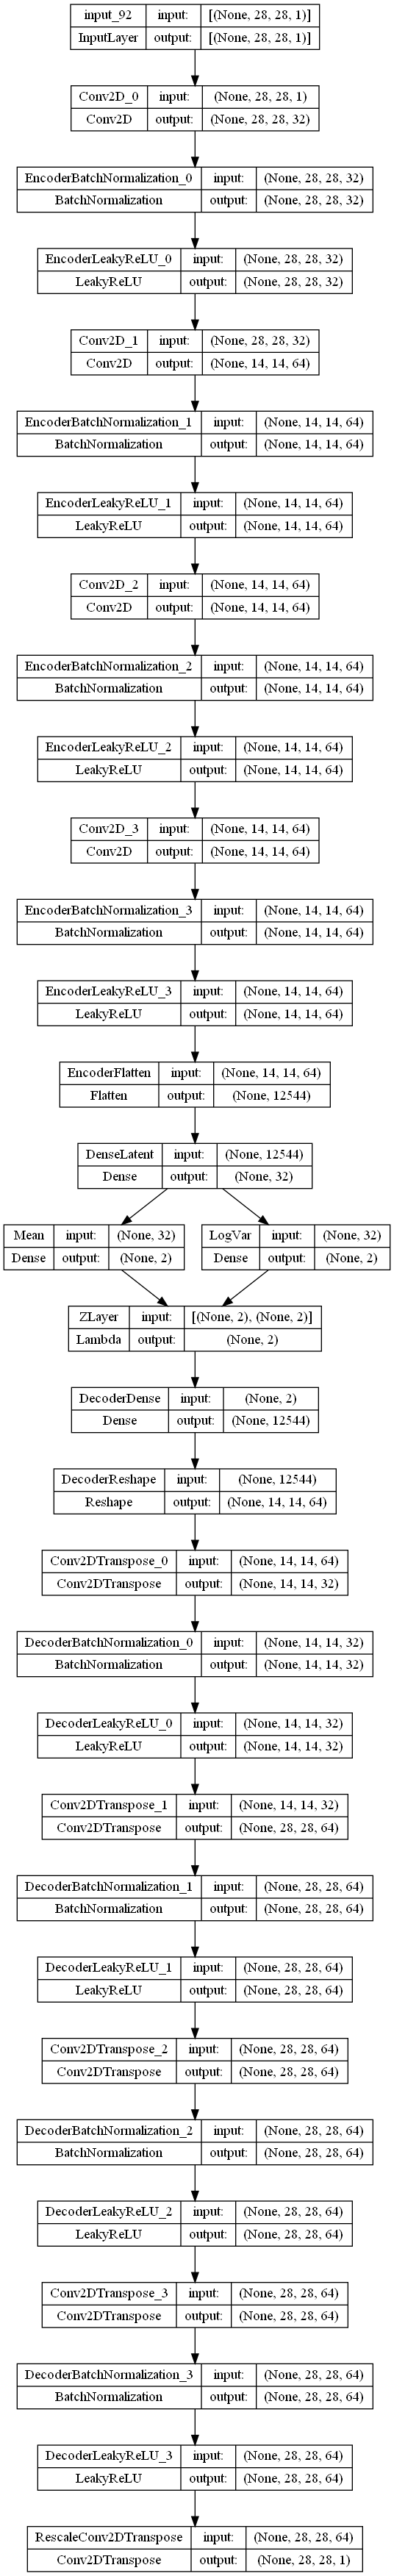

In [214]:
plot_model(vae, show_shapes=True, show_layer_names=True)

In [208]:
encoder = Encoder()
latent = Latent(encoder)
sampling = Sampling(latent)
decoder = Decoder(sampling)

vae =  VAE(encoder, latent, sampling, decoder).build_model()
vae.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 Encoder (Encoder)              (None, 3136)         93568       ['Input[0][0]']                  
                                                                                                  
 Latent (Latent)                [(None, 2),          194084      ['Encoder[0][0]']                
                                 (None, 2)]                                                       
                                                                                                  
 Sampling (Sampling)            (None, 2)            194084      ['Latent[0][0]',          

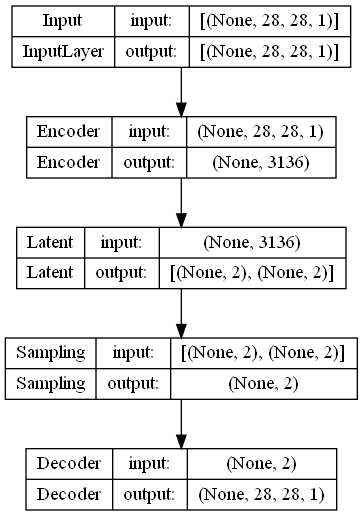

In [209]:
plot_model(vae, show_shapes=True, show_layer_names=True)

# Main

In [274]:
train = pd.read_csv('data/mnist_train_small.csv')
test = pd.read_csv('data/mnist_test_small.csv')

x_train = train.drop('label', axis = 1).to_numpy()
x_train = x_train.astype('float32') / 255.0

x_test = test.drop('label', axis = 1).to_numpy()
x_test = x_test.astype('float32') / 255.0

# reshape dataset to have a single channel
# Reshape (20000,784) ->  (2000,     28,     28,     1)
x_test = x_test.reshape(x_test.shape[0],28,28,1)
x_train = x_train.reshape(x_train.shape[0],28,28,1)
y_data = train['label'].to_numpy()

x_train = x_train[:2000]
x_test = x_test
y_data = y_data[:2000]

In [269]:
print(x_train.shape)
print(y_data.shape)

(2000, 28, 28, 1)
(2000,)


In [275]:
encoder = Encoder()
latent = Latent(encoder)
sampling = Sampling(latent)
decoder = Decoder(sampling)

vae =  VAE(encoder, latent, sampling, decoder, alpha = 1000, beta = 1)

vae.compile(optimizer = Adam(learning_rate=0.0005))
history = vae.fit(x_train, x_train, epochs = 100, batch_size = 32, shuffle = True, validation_data=(x_test, x_test), validation_freq = 15 )

Epoch 1/100
63/63 [==============================] - 11s 149ms/step - loss: 953.8436 - reconstruction_loss: 611.3929 - kl_loss: 10.4976
Epoch 2/100
63/63 [==============================] - 9s 146ms/step - loss: 369.2272 - reconstruction_loss: 311.5073 - kl_loss: 36.7336
Epoch 3/100
63/63 [==============================] - 9s 145ms/step - loss: 271.1073 - reconstruction_loss: 259.1968 - kl_loss: 8.4660
Epoch 4/100
63/63 [==============================] - 9s 147ms/step - loss: 256.1416 - reconstruction_loss: 244.6420 - kl_loss: 8.0953
Epoch 5/100
63/63 [==============================] - 9s 145ms/step - loss: 243.6453 - reconstruction_loss: 235.2272 - kl_loss: 7.7118
Epoch 6/100
63/63 [==============================] - 9s 146ms/step - loss: 236.4859 - reconstruction_loss: 228.7831 - kl_loss: 7.2794
Epoch 7/100
63/63 [==============================] - 9s 144ms/step - loss: 230.7990 - reconstruction_loss: 222.7369 - kl_loss: 6.7795
Epoch 8/100
63/63 [==============================] - 9s 145

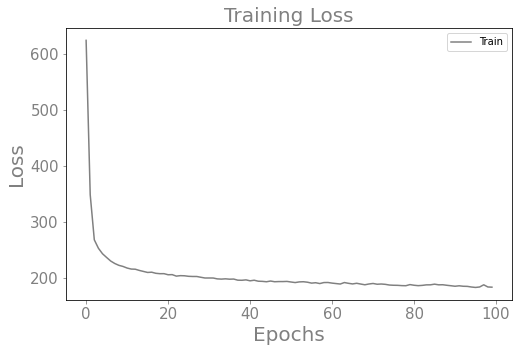

In [276]:
fig, axs = plt.subplots(figsize=(8,5))

axs.plot(history.history['loss'], color = 'gray')
axs.set_title('Training Loss', color = 'gray',fontsize =20)
axs.set_xlabel('Epochs', color = "gray", fontsize =20)
axs.set_ylabel('Loss', color = "gray", fontsize =20)
axs.tick_params(axis ='both', colors = 'gray', labelsize = 15)
axs.legend(['Train'])

plt.show()

63/63 [==============================] - 3s 49ms/step


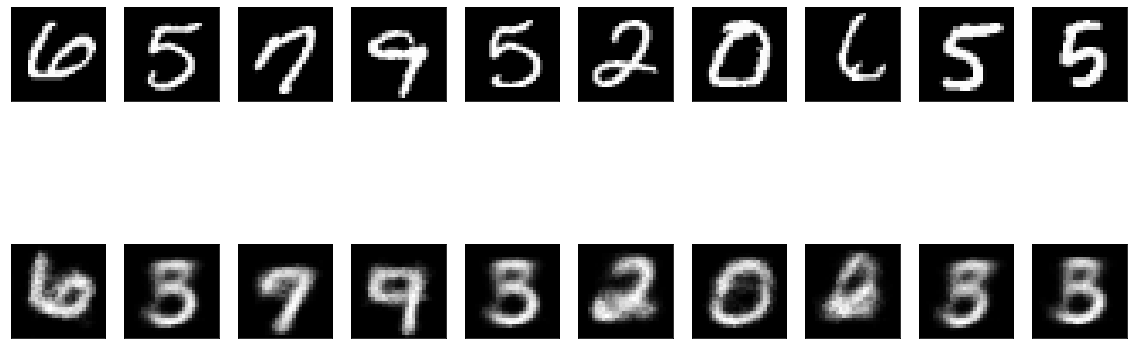

In [277]:
n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    # Original images
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_train[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Reconstructed images
    vae.predict(x_train)
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(vae.predict(x_train)[0][i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [278]:
def plot_latent_space(latent_representations, sample_labels):
    plt.figure(figsize=(20, 10))
    plt.scatter(latent_representations[:, 0],
                latent_representations[:, 1],
                cmap="rainbow",
                c=sample_labels,
                alpha=1,
                s=80)
    plt.colorbar()
    plt.show()


63/63 [==============================] - 3s 53ms/step


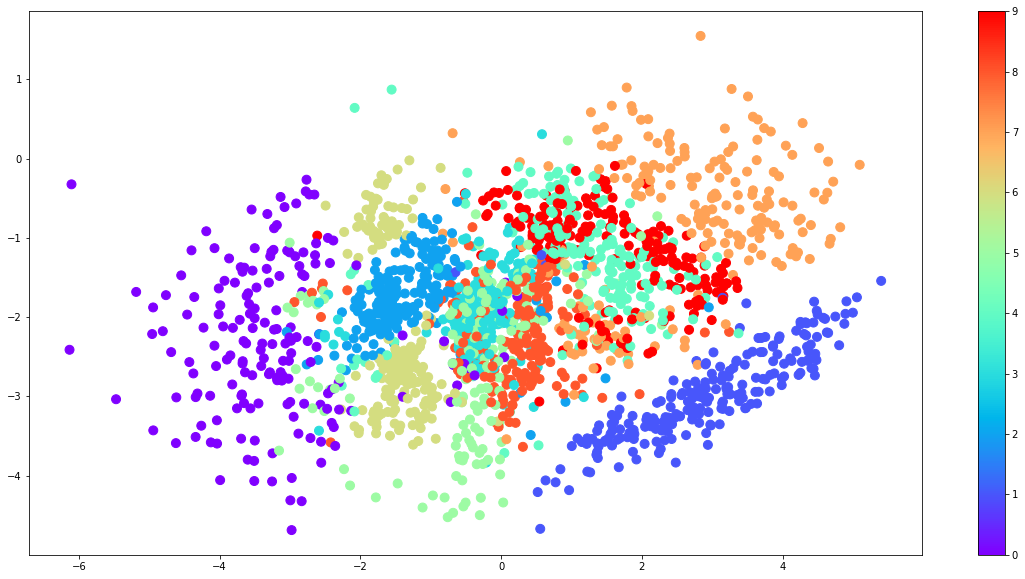

In [279]:
z_mean = vae.predict(x_train)[1]
plot_latent_space(z_mean, y_data)